<a href="https://colab.research.google.com/github/shraddha-an/Dataset-Randomizer/blob/master/ner_task_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ML flow to track metrics
!pip install mlflow --quiet

# Pyngrok to tunnel into a port
!pip install pyngrok --quiet

# Installing torchtext version 0.8.0
!pip install torchtext==0.8.1 --quiet

#torchtext.__version__

     |████████████████████████████████| 14.2MB 209kB/s 
     |████████████████████████████████| 378kB 40.6MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 163kB 40.6MB/s 
     |████████████████████████████████| 1.1MB 26.4MB/s 
     |████████████████████████████████| 153kB 46.0MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 747kB 8.4MB/s 
     |████████████████████████████████| 7.0MB 10.4MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


### **1) Loading data**

In [ ]:
# Importing libraries
import pandas as pd, numpy as np
import torch, torchtext

# Visualization
import matplotlib.pyplot as plt, seaborn as sb

# ml flow
#import mlflow

import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

torchtext.__version__

'0.8.1'

In [ ]:
# Setting random seeds for reproducibility
seed = 46

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# Function that'll parse the text file and return lists of words & ner tags
def text_file_parser(loc: str):

  # Creating lists to hold words and ner tag
  words, ner_tag = [], []

  # Getting the list of all words and tags from the text files
  with open(loc) as file:
    for line in file:

      # Stripping those pesky newline characters
      line = line.strip()

      if line != '-DOCSTART- -X- -X- O' and line != '':
        tokens = line.split(' ')
        
        # Getting rid of punctuations
        if tokens[0].isalpha():
          words.append(tokens[0].lower())
          ner_tag.append(tokens[3])
    
  return words, ner_tag 

# Getting the train & eval dataset
train_words, train_ner = text_file_parser('eng_train.txt')

eval_words, eval_ner = text_file_parser('eng_testa.txt')

test_words, test_ner = text_file_parser('eng_testb.txt')

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

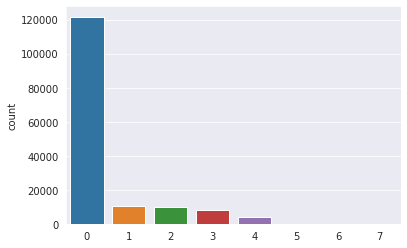

In [ ]:
# Taking a look at the distribution of NER Tags
sb.set_style('darkgrid')
sb.countplot(train_ner_tags)

In [ ]:
ner_vocab.freqs

Counter({'B-LOC': 11,
         'B-MISC': 31,
         'B-ORG': 24,
         'I-LOC': 7878,
         'I-MISC': 4155,
         'I-ORG': 9648,
         'I-PER': 10709,
         'O': 121695})

In [ ]:
# Adjusting class weights to reduce class imbalance.
p = ner_vocab.freqs
weight = [p[k] for k in p.keys()]
total_weight = sum(weight)
class_weights = [total_weight/c for c in weight]

class_weights = torch.tensor(class_weights, device = device)
class_weights

tensor([1.5978e+01, 1.2667e+00, 3.7100e+01, 1.4395e+01, 1.9567e+01, 1.4014e+04,
        4.9726e+03, 6.4230e+03], device='cuda:0')

### **2) Torch text for tokenizing and batching data**

In [ ]:
#  -------------- Using torchtext Fields to handle text and tags data processing  -------------
from torchtext.data import Example, Field, BucketIterator, Dataset

# Creating Fields to handle text data and tags. Setting unk_token = False for tag field.
text = Field(lower = True)
tags = Field(unk_token = None, pad_token = None)

fields = (('text', text), ('tags', tags))

# Creating an Example object of each element in train_words. Appending to a list. Creating a Dataset object.
def dataset_creator(text_list, tag_list):
  train_list = []

  for x, y in zip(text_list, tag_list):
    train_list.append(Example.fromlist([x, y], fields = fields))

  # Creating a Dataset object out of the examples and fields
  train_data = Dataset(examples = train_list, fields = fields)

  return train_data

# Creating Datasets from a list of words and tags
train_data = dataset_creator(train_words, train_ner)
eval_data = dataset_creator(eval_words, eval_ner)
test_data = dataset_creator(test_words, test_ner)

# Building vocabulary using build_vocab
text.build_vocab(train_data, max_size = vocab_size - 2)
tags.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(text.vocab)}")
print(f"Unique tokens in TAG vocabulary: {len(tags.vocab)}")

Unique tokens in TEXT vocabulary: 15978
Unique tokens in TAG vocabulary: 8


In [ ]:
for i in range(5):
  print(vars(train_data.examples[i]))

{'text': ['eu'], 'tags': ['I-ORG']}
{'text': ['rejects'], 'tags': ['O']}
{'text': ['german'], 'tags': ['I-MISC']}
{'text': ['call'], 'tags': ['O']}
{'text': ['to'], 'tags': ['O']}


In [ ]:
print(text.vocab.freqs.most_common(4))

[('the', 8390), ('of', 3815), ('in', 3621), ('to', 3424)]


In [ ]:
# Setting batch_size
batch_size = 32

# Creating a bucket iterator
# Defines an iterator that batches examples of similar lengths together.
# Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

train_iterator = BucketIterator(dataset = train_data, batch_size = batch_size, shuffle = True, device = device)

eval_iterator = BucketIterator(dataset = eval_data, batch_size = batch_size, shuffle = False, device = device)

test_iterator = BucketIterator(dataset = test_data, batch_size = batch_size, shuffle = False, device = device)

### **3) Model definition**

In [119]:
# Model
import torch.nn as nn
import torch.nn.functional as F

class Ner(nn.Module):

    # Defining layer architecture inside the constructor method
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_classes, bidirectional = False):
        
        # Calling the parent class constructor
        super(Ner, self).__init__()

        # Embedding Layer
        self.embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size = embed_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = 1, 
                            bidirectional = bidirectional,
                            bias = False)

        # output_shape = num_directions * hidden_size
        # Fully-connected layer for classification
        self.fc = nn.Linear(in_features = hidden_dim * 2 if bidirectional else hidden_dim, out_features = output_classes)

    # Forward pass
    def forward(self, word):
      x = self.embed(word)
      x, states = self.lstm(x)
      x = x[:, -1]
      x = self.fc(x)
      x = F.log_softmax(x, dim = 1)

      return x

# Setting up some parameters
vocab_size = len(text.vocab)
embed_dim = 24
output_classes = len(set(train_ner_tags))  
hidden_dim = 12
bidirectional = True

lr = 0.001 #0.001

# Epochs 
epochs = 10


# Instantiating the model
model = Ner(vocab_size = vocab_size, 
            embed_dim = embed_dim,
            hidden_dim = hidden_dim,
            output_classes = output_classes,
            bidirectional = bidirectional)

model.to(device)

# Optimizer
from torch.optim import Adam

optimizer = Adam(model.parameters())

# Criterion
criterion = nn.NLLLoss(weight = class_weights)
#criterion = nn.CrossEntropyLoss(weight = class_weights)


# Track these parameters also
class Params(object):
    def __init__(self, batch_size, epochs, lr, hidden_dim, bidirectional, seed, cuda, embed_dim, vocab_size, criterion):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.seed = seed
        self.cuda = cuda
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.criterion = criterion
 

args = Params(batch_size = batch_size, epochs = epochs, lr = lr, hidden_dim = hidden_dim, bidirectional = bidirectional,
              seed = seed, cuda = True, embed_dim = embed_dim, vocab_size = vocab_size,
              criterion = criterion)
 
# Model Summary
model

Ner(
  (embed): Embedding(15978, 24)
  (lstm): LSTM(24, 12, bias=False, bidirectional=True)
  (fc): Linear(in_features=24, out_features=8, bias=True)
)

### **4) Training**

In [120]:
# Sklearn metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score
import mlflow

# Training loop

# Putting model in train mode
model.train()

# Metrics dict
metrics = {}

print('------------  Training  --------------')

# Setting an ML flow experiment
mlflow.set_experiment("NER CoNLL task")

# Stopping any active runs
if mlflow.active_run(): mlflow.end_run()

# Training + starting an active ml flow run
mlflow.start_run(run_name = "Train/Evaluation/Test metrics of NER classifier")

# Log parameters in mlflow
for key, value in vars(args).items():
    mlflow.log_param(key, value)

for epoch in range(epochs):

  # Calculating training accuracy & loss for every epoch
  total_acc, total_count, train_loss = 0, 0, 0.0

  # Collecting predictions and true labels for each epoch
  preds, true_labels = [], []

  # Training batches
  for batch in train_iterator:
    
    # Extract sequences & tags
    sequences, tags = batch.text, batch.tags

    # Sequences is stored as list of list, so only extracting the 1-D list and reshaping shape from 1-D to 2-D
    sequences = sequences[0].reshape(-1, 1)
    tags = tags[0]

    # Clear out gradients from previous training batch
    optimizer.zero_grad()

    # Forward pass; feed inputs to model & get outputs
    outputs = model(sequences)
  
    # Calculate loss between model's predictions & actual target
    # print(outputs.size(), '\n\n', tags.size())
    loss = criterion(outputs, tags)

    # Back propagate loss throughout the neural network
    loss.backward()

    # Update parameters based on the current gradient
    optimizer.step()

    # Converting the softmax scores to labels
    predicted_label = outputs.argmax(1)
    
    preds.append(predicted_label.detach().cpu().numpy())
    true_labels.append(tags.to('cpu').numpy())

    # Calculating accuracy & loss
    total_acc += (predicted_label == tags).sum().item()
    total_count += tags.size(0)

    train_loss += loss.item()
  
  # Unraveling lists
  preds = [pred for array in preds for pred in array]
  true_labels = [target for array in true_labels for target in array]

  # Precision, Recall & Accuracy
  train_precision = round(precision_score(preds, true_labels, average = 'macro'), 4)
  train_recall = round(recall_score(preds, true_labels, average = 'macro'), 4)
  
  loss_ = round(train_loss/len(train_iterator), 4)
  train_accuracy = round(total_acc/ total_count, 4)
  
  # Tracking with MLFlow
  mlflow.log_metric("train_accuracy", train_accuracy)
  mlflow.log_metric("train_precision", train_precision)
  mlflow.log_metric("train_recall", train_recall)
  mlflow.log_metric("train_loss", loss_)
  
  print('\nEpoch {}/{}\n---------'.format(epoch + 1, epochs))
  print('Loss: {}     Accuracy: {}      Precision: {}     Recall: {}     '.format(loss_, train_accuracy, train_precision, train_recall))

# Saving the metrics
metrics['train_run'] = {'Accuracy': train_accuracy, 'Precision': train_precision, 'Recall': train_recall, 'Loss': loss_}

#mlflow.end_run()

------------  Training  --------------

Epoch 1/10
---------
Loss: 0.7237     Accuracy: 0.7778      Precision: 0.1463     Recall: 0.2176     

Epoch 2/10
---------
Loss: 0.4731     Accuracy: 0.8181      Precision: 0.2752     Recall: 0.4035     

Epoch 3/10
---------
Loss: 0.3661     Accuracy: 0.8482      Precision: 0.4247     Recall: 0.4049     

Epoch 4/10
---------
Loss: 0.3051     Accuracy: 0.8638      Precision: 0.5038     Recall: 0.5207     

Epoch 5/10
---------
Loss: 0.2655     Accuracy: 0.8764      Precision: 0.6088     Recall: 0.567     

Epoch 6/10
---------
Loss: 0.2382     Accuracy: 0.8928      Precision: 0.6454     Recall: 0.576     

Epoch 7/10
---------
Loss: 0.2184     Accuracy: 0.9058      Precision: 0.6952     Recall: 0.6026     

Epoch 8/10
---------
Loss: 0.2033     Accuracy: 0.9161      Precision: 0.7335     Recall: 0.6248     

Epoch 9/10
---------
Loss: 0.1919     Accuracy: 0.9247      Precision: 0.7526     Recall: 0.6423     

Epoch 10/10
---------
Loss: 0.185  

### **5) Evaluation**

In [121]:
# Evaluating on evaluation set ~ eng_testa.txt
# Putting model in eval mode
model.eval()

# Variables to track predictions & target
preds, targets = [], []

# Accuracy
eval_acc, eval_count, eval_loss = 0, 0, 0.0

# Iterating through batches in the test dataloader
for batch in eval_iterator:

# Extract sequences & tags
  sequences, tags = batch.text, batch.tags
  #print(sequences, '\n\n', tags)
  
  # Sequences is stored as list of list, so only extracting the 1-D list and reshaping shape from 1-D to 2-D
  sequences = sequences[0].reshape(-1, 1)
  tag = tags[0]
  
  #print(sequences, '\n\n', tags)
  # Feeding inputs to the model
  output = model(sequences)

  # Calculate loss between model's predictions & actual target
  loss = criterion(output, tag)
  eval_loss += loss.item()
  
  # Deatch predictions from the graph and append to list
  preds.append(output.argmax(1).detach().cpu().numpy())
  targets.append(tag.to('cpu').numpy())

  # Identifying the correctly predicted labels
  eval_acc += (output.argmax(1) == tag).sum().item()
  eval_count += tag.size(0)


# Evaluation Accuracy
eval_accuracy = round(eval_acc/eval_count, 4)
eval_loss = round(eval_loss/len(eval_iterator), 9)

# Unraveling lists
preds = [pred for array in preds for pred in array]
true_labels = [target for array in targets for target in array]

# Precision, Recall & Accuracy
eval_precision = round(precision_score(preds, true_labels, average = 'macro'), 4)
eval_recall = round(recall_score(preds, true_labels, average = 'macro'), 4)

print('Evaluation\n\nLoss: {}     Precision: {}     Recall: {}      Accuracy: {}'.format(eval_loss, eval_precision, eval_recall, eval_accuracy))

# Tracking them metrics
mlflow.log_metric("eval_accuracy", eval_accuracy)
mlflow.log_metric("eval_precision", eval_precision)
mlflow.log_metric("eval_recall", eval_recall)
mlflow.log_metric("eval_loss", eval_loss)


# Saving the metrics
metrics['evaluation_run'] = {'Accuracy': eval_accuracy, 'Precision': eval_precision, 'Recall': eval_recall, 'Loss': eval_loss}

Evaluation

Loss: 0.290104464     Precision: 0.4599     Recall: 0.5158      Accuracy: 0.9007


### **6) Testing**

In [122]:
# Testing on eng_testb file
# Putting model in eval mode
model.eval()

# Variables to track predictions & target
preds, targets = [], []

# Accuracy
test_acc, test_count, test_loss = 0, 0, 0.0

# Iterating through batches in the test dataloader
for batch in test_iterator:
  
  # Push variables to device
  sequence, tag = batch.text, batch.tags
  
  # Extracting the sequences and tag from list of list
  sequences = sequence[0].reshape(-1, 1)
  tag = tag[0]

  # Feeding inputs to the model
  output = model(sequences)

  # Calculate loss between model's predictions & actual target
  loss = criterion(output, tag)
  test_loss += loss.item()

  # Deatch predictions from the graph and append to list
  preds.append(output.argmax(1).detach().cpu().numpy())
  targets.append(tag.to('cpu').numpy())

  # Identifying the correctly predicted labels
  test_acc += (output.argmax(1) == tag).sum().item()
  test_count += tag.size(0)


# Test Accuracy & loss
test_accuracy = round(test_acc/test_count, 4)
test_loss = round(test_loss/len(test_iterator), 4)

# Unraveling lists
preds = [pred for array in preds for pred in array]
true_labels = [target for array in targets for target in array]

# Precision, Recall & Accuracy
test_precision = round(precision_score(preds, true_labels, average = 'macro'), 4)
test_recall = round(recall_score(preds, true_labels, average = 'macro'), 4)

print('Testing \n\nLoss: {}     Precision: {}     Recall: {}      Accuracy: {}'.format(test_loss, test_precision, test_recall, test_accuracy))

# Tracking them metrics
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_precision", test_precision)
mlflow.log_metric("test_recall", test_recall)
mlflow.log_metric("test_loss", test_loss)

# Saving the metrics
metrics['test_run'] = {'Accuracy': test_accuracy, 'Precision': test_precision, 'Recall': test_recall, 'Loss': test_loss}

mlflow.end_run()

Testing 

Loss: 0.4641     Precision: 0.3779     Recall: 0.4844      Accuracy: 0.8598


### **7) ML flow UI**

In [123]:
# Create remote tunnel using ngrok to allow local port access
from pyngrok import ngrok

# Set the port for mlflow UI 
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if they exist
ngrok.kill()

# Setting up auth token
NGROK_AUTH_TOKEN = "1qk6KrMTlhKWnSdPGaDLvhiX75k_g7tSEN89evvPDpNEDDk4"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 
ngrok_tunnel = ngrok.connect(addr = "5000", proto = "http", bind_tls = True)

print("MLflow's UI to view tracked metrics:", ngrok_tunnel.public_url)

MLflow's UI to view tracked metrics: https://7742f5b8a746.ngrok.io


In [124]:
from pprint import pprint
pprint(metrics)

{'evaluation_run': {'Accuracy': 0.9007,
                    'Loss': 0.290104464,
                    'Precision': 0.4599,
                    'Recall': 0.5158},
 'test_run': {'Accuracy': 0.8598,
              'Loss': 0.4641,
              'Precision': 0.3779,
              'Recall': 0.4844},
 'train_run': {'Accuracy': 0.93,
               'Loss': 0.185,
               'Precision': 0.7566,
               'Recall': 0.6555}}
